In [2]:
# import gym
from env.decom_lunar_lander import LunarLander as LunarLander_decom_reward
import torch
from torch import nn
from torch.autograd import variable
import time
import os
import shutil
import numpy as np

from tqdm import tqdm
from random import uniform, randint, sample, random, choices
from collections import deque

import io
import base64
from IPython.display import HTML

from models.feature_q_model import feature_q_model
from models.dqn_model import DQNModel
from memory.memory import ReplayBuffer, ReplayBuffer_decom

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import math
import pylab
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from tensorboardX import SummaryWriter
%matplotlib inline

FloatTensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor
%config InlineBackend.figure_format = 'retina'

In [3]:
# Set the Env name and action space for CartPole
# Register the environment


ENV_NAME = 'LunarLander_GVF_seq_clusters'
env = LunarLander_decom_reward()

# Move left, Move right
ACTION_DICT = {
    "NOOP": 0,
    "LEFT":1,
    "MAIN":2,
    "RIGHT":3
}

In [4]:
# Set result saveing floder
result_floder = ENV_NAME
result_file = ENV_NAME + "/results.txt"
if not os.path.isdir(result_floder):
    os.mkdir(result_floder)

In [5]:
hyperparams_Lunarlander = {
    'epsilon_decay_steps' : 200000, 
    'final_epsilon' : 0.01,
    'batch_size' : 128, 
    'update_steps' : 3, 
    'memory_size' : 100000, 
    'beta' : 0.99, 
    'model_replace_freq' : 1,
    'learning_rate' : 0.0001,
    'privous_state' : 1
}
action_name = {
    0: 'Nop',
    1: 'right engine',
    2: 'main engine',
    3: 'left engine'
}

In [6]:
class DQN_agent(object):
    def __init__(self, env, hyper_params, action_space = len(ACTION_DICT)):
        
        self.env = env
        self.max_episode_steps = env._max_episode_steps
        
        """
            beta: The discounted factor of Q-value function
            (epsilon): The explore or exploit policy epsilon. 
            initial_epsilon: When the 'steps' is 0, the epsilon is initial_epsilon, 1
            final_epsilon: After the number of 'steps' reach 'epsilon_decay_steps', 
                The epsilon set to the 'final_epsilon' determinately.
            epsilon_decay_steps: The epsilon will decrease linearly along with the steps from 0 to 'epsilon_decay_steps'.
        """
        self.beta = hyper_params['beta']
        self.initial_epsilon = 1
        self.final_epsilon = hyper_params['final_epsilon']
        self.epsilon_decay_steps = hyper_params['epsilon_decay_steps']

        """
            episode: Record training episode
            steps: Add 1 when predicting an action
            learning: The trigger of agent learning. It is on while training agent. It is off while testing agent.
            action_space: The action space of the current environment, e.g 2.
        """
        self.episode = 0
        self.steps = 0
        self.best_reward = -1000
        self.learning = True
        self.action_space = action_space
        self.privous_state = hyper_params['privous_state']

        """
            input_len The input length of the neural network. It equals to the length of the state vector.
            output_len: The output length of the neural network. It is equal to the action space.
            eval_model: The model for predicting action for the agent.
            target_model: The model for calculating Q-value of next_state to update 'eval_model'.
        """
        state = env.reset()
        self.reward_true_weight = env.reward_true_weight
        
        input_len = len(state) * self.privous_state + action_space
        output_len = 1
        self.state_len = len(state)
        self.decom_reward_len = len(env.reward_true_weight)
        self.action_vector = self.get_action_vector()
        
        self.eval_model = feature_q_model(input_len, self.decom_reward_len, output_len, learning_rate = hyper_params['learning_rate'])
        self.target_model = feature_q_model(input_len, self.decom_reward_len, output_len)
#         memory: Store and sample experience replay.
        self.memory = ReplayBuffer_decom(hyper_params['memory_size'])
        
        """
            batch_size: Mini batch size for training model.
            update_steps: The frequence of traning model
            model_replace_freq: The frequence of replacing 'target_model' by 'eval_model'
        """
        
        self.batch_size = hyper_params['batch_size']
        self.update_steps = hyper_params['update_steps']
        self.model_replace_freq = hyper_params['model_replace_freq']
        
        if os.path.isdir("LunarLander_summary/Lunarlander/GQF/"):
            shutil.rmtree("LunarLander_summary/Lunarlander/GQF/")

        self.q_value_gd = []
        self.v_feature_input= []
        self.loss_accumulate = deque(maxlen=1000)
        
        self.optimizer_com = self.eval_model.optimizer_com
        self.loss_fn = self.eval_model.loss_fn
        
        
    # Linear decrease function for epsilon
    def linear_decrease(self, initial_value, final_value, curr_steps, final_decay_steps):
        decay_rate = curr_steps / final_decay_steps
        if decay_rate > 1:
            decay_rate = 1
        return initial_value - (initial_value - final_value) * decay_rate
    
    def get_action_vector(self):
        action_vector = np.zeros((self.action_space, self.action_space))
        for i in range(len(action_vector)):
            action_vector[i, i] = 1
        
        return FloatTensor(action_vector)
    
    def concat_state_action(self, states, actions = None, is_full_action = False):
        if is_full_action:
            com_state = FloatTensor(states).repeat((1, self.action_space)).view((-1, self.state_len))
            actions = self.action_vector.repeat((len(states), 1))
        else:
            com_state = states.clone()
            actions = actions.clone()
        state_action = torch.cat((com_state, actions), 1)
        return state_action
        
    def explore_or_exploit_policy(self, state):
        p = uniform(0, 1)
        # Get decreased epsilon
        epsilon = self.linear_decrease(self.initial_epsilon, 
                               self.final_epsilon,
                               self.steps,
                               self.epsilon_decay_steps)
        
        if p < epsilon:
            #return action, None
            return randint(0, self.action_space - 1)
        else:
            #return action, Q-value
            return self.greedy_policy(state)[0]
        
    def greedy_policy(self, state):
        state_ft = FloatTensor(state).view(-1, self.state_len)
        state_action = self.concat_state_action(state_ft, is_full_action = True)
        feature_vectors, q_values = self.eval_model.predict_batch(state_action)
        q_v, best_action = q_values.max(0)
        return best_action.item(), q_v, feature_vectors[best_action.item()]
    
    def update_batch(self):
#         print(self.update_steps)
        if len(self.memory) < self.batch_size or self.steps % self.update_steps != 0:
            return

        batch = self.memory.sample(self.batch_size)

        (states_actions, _, reward, next_states,
         is_terminal, rewards_decom) = batch
        
#         states_actions = states_actions
        next_states = FloatTensor(next_states)
        terminal = FloatTensor([1 if t else 0 for t in is_terminal])
        reward = FloatTensor(reward)
        rewards_decom = FloatTensor(rewards_decom)
        batch_index = torch.arange(self.batch_size,
                                   dtype=torch.long)
        
        # Current Q Values
        feature_vector, q_values = self.eval_model.predict_batch(states_actions)
        next_state_actions = self.concat_state_action(next_states, is_full_action = True)
        feature_vector_next, q_next = self.target_model.predict_batch(next_state_actions)
        q_next = q_next.view((-1, self.action_space))
        feature_vector_next = feature_vector_next.view((-1, self.action_space, self.decom_reward_len))
        q_max, idx = q_next.max(1)
        
        feature_vector_max = feature_vector_next[batch_index, idx, :]
    
        q_max = (1 - terminal) * q_max
        q_target = reward + self.beta * q_max
        q_target = q_target.unsqueeze(1)
        
        feature_vector_max = (1 - terminal.view(-1, 1)) * feature_vector_max
        feature_vector_target = rewards_decom + self.beta * feature_vector_max
        self.eval_model.fit(q_values, q_target, feature_vector, feature_vector_target)
        
    def learn_and_evaluate(self, training_episodes, test_interval):
        test_number = training_episodes // test_interval
        all_results = []
        
        for i in range(test_number):
            # learn
            self.learn(test_interval)
            
            # evaluate
            avg_reward = self.evaluate()
            all_results.append(avg_reward)
            
        return all_results
    
    def learn(self, test_interval):
        for episode in tqdm(range(test_interval), desc="Training"):
            state = self.env.reset()
            done = False
            steps = 0
            
            while steps < self.max_episode_steps and not done:
                steps += 1
                self.steps += 1
                
                action = self.explore_or_exploit_policy(state)
                next_state, reward, done, _, rewards_decom = self.env.step(action)
                action_vector = np.zeros(self.action_space)
                action_vector[action] = 1
                self.memory.add(np.concatenate((state.copy(), action_vector.copy()), axis=0), -1, reward, next_state, done, rewards_decom)
                self.update_batch()
                
                if self.steps % self.model_replace_freq == 0:
                    self.target_model.replace_soft(self.eval_model)
                state = next_state
                
    def evaluate(self, trials = 50):
        total_reward = 0
        total_steps = 0
        for _ in tqdm(range(trials), desc="Evaluating"):
            state = self.env.reset()
            done = False
            steps = 0
            
            while steps < self.max_episode_steps and not done:
                steps += 1
                action = self.greedy_policy(state)[0]
                state, reward, done, _, rewards_decom = self.env.step(action)
                total_reward += reward
            total_steps += steps
        avg_reward = total_reward / trials
        print(avg_reward, total_steps / trials)
#         if avg_reward >= self.best_reward:
#             self.best_reward = avg_reward
#             self.save_model()
#             print("save")
        self.best_reward *= 0.99
        return avg_reward
    
    def collect_GVF_seq(self, data_len):
        total_reward = 0
        total_steps = 0
        trials = 0
        GVF_seq_dataset = []
        pbar = tqdm()
        while data_len > total_steps:
            state = self.env.reset()
            done = False
            steps = 0
            
            while steps < self.max_episode_steps and not done:
                steps += 1
                action, _, GVF_pred = self.greedy_policy(state)
                state, reward, done, _, rewards_decom = self.env.step(action)
                total_reward += reward
                GVF_seq_dataset.append(GVF_pred.tolist())
                
            total_steps += steps
            trials += 1
            pbar.update(steps)
        print("average reward: ", total_reward / trials, "average steps: ", total_steps / trials, "data length: ", len(GVF_seq_dataset))
        return GVF_seq_dataset
    
#     def save_model(self):
#         self.eval_model.save("LL_learned_model" + '/best_model.pt')

    def get_GVF_seq(self):
        state = self.env.reset()
        done = False
        steps = 0
        GVF_seq_dataset = []
        all_frames = []
        while steps < self.max_episode_steps and not done:
            steps += 1
            action, _, GVF_pred = self.greedy_policy(state)
            all_frames.append(env.render(mode='rgb_array'))
            state, _, done, _, _ = self.env.step(action)
            GVF_seq_dataset.append(GVF_pred.tolist())
            
        return FloatTensor(np.array(GVF_seq_dataset)), all_frames
    # load model
    def load_model(self):
        self.eval_model.load("LL_learned_model" + '/best_model.pt')

In [7]:
agent = DQN_agent(env, hyperparams_Lunarlander)
agent.load_model()

Using GPU
0.0001
Using GPU
0.0001


/home/xian/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
GVF_seq_dataset = agent.collect_GVF_seq(50000)

50073it [00:42, 1330.40it/s]

average reward:  242.328868784806 average steps:  287.7758620689655 data length:  50073


In [9]:
GVF_seq_dataset = FloatTensor(np.array(GVF_seq_dataset))
torch.save(GVF_seq_dataset, "LunarLander_GVF_seq_clusters/GVF_seq_dataset.pt")

## K-means

In [10]:
import torch
from tqdm import tqdm
import numpy as np
from kmeans import cluster, KNN_clustering
from utils import normalization, draw_cluster_on_frame, display_frames_as_gif

### choosing K


100%|██████████| 10/10 [00:00<00:00, 15.34it/s]

100%|██████████| 10/10 [00:00<00:00, 19.59it/s]

100%|██████████| 10/10 [00:00<00:00, 21.67it/s][A

100%|██████████| 10/10 [00:00<00:00, 21.70it/s][A

100%|██████████| 10/10 [00:00<00:00, 21.10it/s][A

100%|██████████| 10/10 [00:00<00:00, 20.64it/s][A

100%|██████████| 10/10 [00:00<00:00, 19.95it/s][A

100%|██████████| 10/10 [00:00<00:00, 19.69it/s]

100%|██████████| 10/10 [00:00<00:00, 19.03it/s]


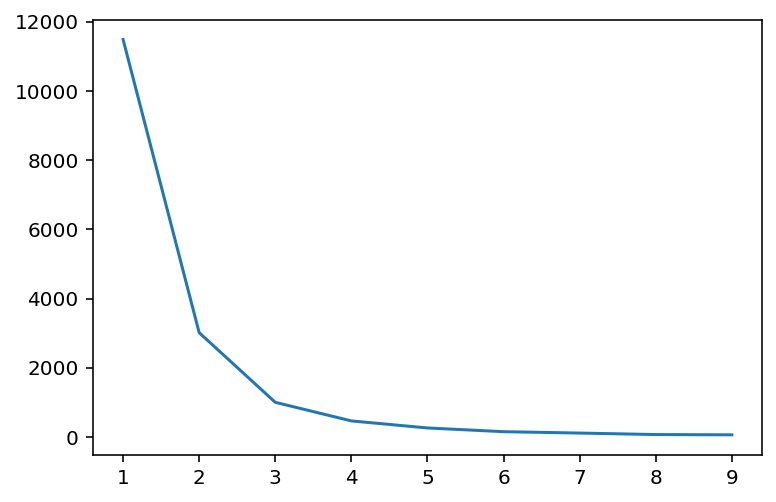

In [11]:
GVF_seq_dataset = torch.load("LunarLander_GVF_seq_clusters/GVF_seq_dataset.pt")
# GVF_seq_dataset = normalization(GVF_seq_dataset)
variences = []
k_range = range(1, 10)
for i in k_range:
    k_means, varience = cluster(GVF_seq_dataset, k = i, verbose = False)
    variences.append(varience)
plt.plot(list(k_range), variences)
plt.show()


In [19]:
K = 5
k_means, varience = cluster(GVF_seq_dataset, k = K, it = 50, verbose = False)
print(varience)
torch.save(k_means, "LunarLander_GVF_seq_clusters/kmeans_10.pt".format(K))


100%|██████████| 50/50 [00:02<00:00, 20.64it/s]

tensor(256.0596, device='cuda:0')


## Clustering GVF Seq

In [20]:
FEATRUESNAME = ["F1 Distance", "F2 Velocity", "F3 Tilt-angle", "F4 Right landing leg", 
                "F5 Left Landing Leg", "F6 Main Engine Uses", "F7 Side Engine Uses", "F8 Landing"]
def plot_GVF_seq_and_clusters(GVF_seq, seq_clusters, K):
    x_values = [x for x in range(len(GVF_seq))]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.xlabel("steps")
    plt.ylabel('GVF values')
    plt.title("GVF sequence clusters")
    for i in range(len(GVF_seq[0])):
        plt.plot(x_values, GVF_seq[:, i].tolist(), label = FEATRUESNAME[i])
    
    is_labeled = [False] * K
    for i, c in enumerate(seq_clusters):
        c = int(c)
        plt.axvspan(i, i + 1, facecolor=colors[c], alpha=0.5, label = "cluster {}".format(c) if not is_labeled[c] else None)
        is_labeled[c] = True
    plt.legend(bbox_to_anchor=(0.5,-0.3), loc='lower center', ncol=4, fontsize='small',)
    plt.show()

Using GPU
0.0001
Using GPU
0.0001


/home/xian/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 0., 0., 0., 0., 4., 4., 4., 4., 4., 4., 1., 1.,
        1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2.], device='cuda:0')
tensor([[-6.5422e-01, -1.3918e-01,  8.0127e-03,  ...,  2.9165e-01,
          2.1618e-01,  

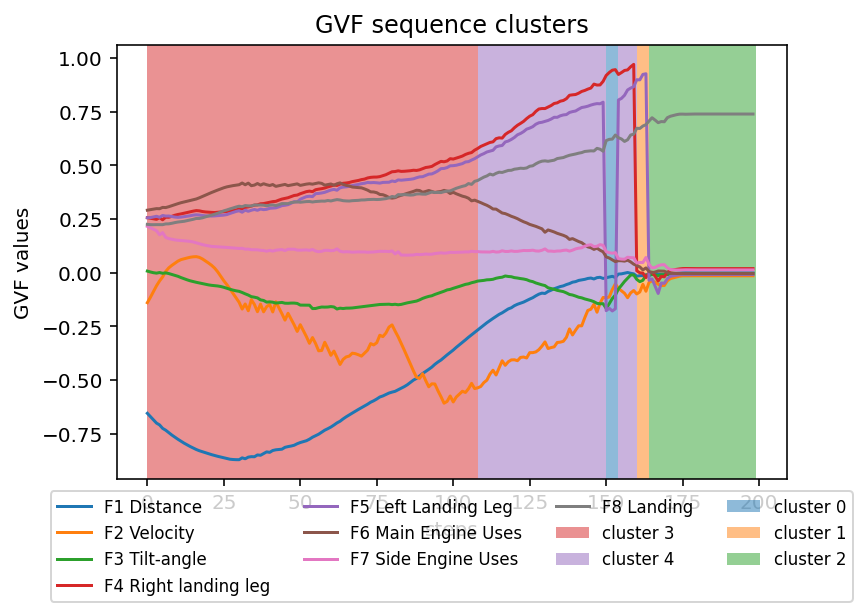

In [23]:
agent = DQN_agent(env, hyperparams_Lunarlander)
agent.load_model()

# k_means = torch.load("LunarLander_GVF_seq_clusters/kmeans_10.pt".format(K))
# one_GVF_seq, frames = agent.get_GVF_seq()
# norm_one_GVF_seq = normalization(one_GVF_seq)
# GVF_seq_clusters= KNN_clustering(norm_one_GVF_seq, k_means)

# k_means = torch.load("LunarLander_GVF_seq_clusters/kmeans_{}.pt".format(K))
one_GVF_seq, frames = agent.get_GVF_seq()
# norm_one_GVF_seq = normalization(one_GVF_seq)
GVF_seq_clusters= KNN_clustering(one_GVF_seq, k_means)
print(GVF_seq_clusters)
all_added_frames = draw_cluster_on_frame(GVF_seq_clusters, frames, K)
print(one_GVF_seq)
plot_GVF_seq_and_clusters(one_GVF_seq, GVF_seq_clusters, K)

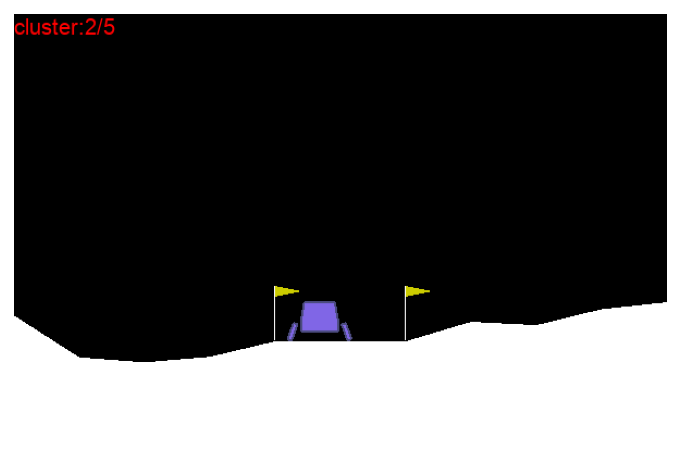

In [24]:
display_frames_as_gif(all_added_frames, "LunarLander_GVF_seq_clusters", "GVF_clusters_{}_video.mp4".format(K))